## Extraction of Shock Models from Human Driving data
- Intelligent Driving Model (IDM) is the driving behaviour of an average driver and does not include all possible cases of human driving (some more aggressive, some more timid than average). Even a shochastic IDM model (which adds a random noise to deterministic IDM) has a noise that is bounded within a certain range.

### Step 1: Apply a car-following filter: 
- All vehicles are the same vehicle type (cars)
- No lane change occurs for a period > 10 seconds
- Car-following: The ego car has a leader in front of it at a headway distance <49m (apply 2 seconds rule for 55mph)

### Step 2: From these car followers:
- Extract Acceleration, deceleration events 
- Frequency of such 
- Duration of such

### Step 3: From the Accel/Decel events:
- Extract events for which Acceleration Decelerations are outside the typical 0.2 m/s^2 bounded range.
- The typical range is the average driver.

References (On car-following periods extraction from data): 
1. https://www.sciencedirect.com/science/article/pii/S0968090X18308635
2. https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6728339&tag=1
------------------------

### Data: 

Souce of data: [link](https://datahub.transportation.gov/stories/s/i5zb-xe34)

Among other things, the data includes two straight/highway road sections.

| Property        | I80 freeway | US Route 101 |
|------------------|-------------|--------------|
| Total distance (study area)  | 502m        | 640m         |
| Speed limit      | 65mph       |   55mph      |
| Total time (to travel at speed limit) |      17.3s       |        26s      |

- We selected US 101 (Hollywood Freeway) for our study because:
    - Since it has 55mph speed limit (desired velocity for vehicles) a lower headway distance (49m) is required for free flow.
    - The study area is 640m so, there will be a large number of long trajectories and consequenctly a higher chance for a large number of car-following events (greater than the 10 second threshold) to be present in the data.
    - Our study occurs at 22mph (10 m/s desired velocity) and 55mph is closer to this than 65mph.
    

- All three 15 minute time windows for this road are analyzed 
--------------

All attributes:
- Vehicle_ID: 
- Frame_ID: 
- Total_Frames: Total number of frames for which a vehicle appears in the data
- Global_Time: 
- Local_X:
- Local_Y:
- Global_X:
- Global_Y:
- v_length : length of vehicle in feet
- v_Width: width of vehicle in feet
- v_Class:
- v_vel: instantaneous valocity in feet/secpmd
- v_Acc: instantaneous acceleration in feet/second squared 
- Lane_ID:
- Preceeding: Vehicle ID of the vehicle in front of the ego (current) vehicle
- Following: ID of the vehicle following. 
- Space Headway: Distance between the front center of a vehicle to the front center of the preceeding vehicle (the one in front)
- Time_Headway: 

Remove the following attributes:  ['Global_X', 'Global_Y','Local_Y','Frame_ID','Following','v_Length', 'v_Width','Following', 'Time_Hdwy']

- Global_X: Not necessary for our extraction
- Global_Y: Same as above
- Local_Y: We will filter w.r.t each lane, Y values are not necessary
- Frame_ID: Total frames is necessary but not frame ID
- Following: Since space headway is measured w.r.t to the Preceeding, we dont need this
- v_Length: We will filter with vehicle class =2 (cars), after that this  column has no use
- v_Width: same as above
- Time_Hdwy: Sapce headway with the preceeding is enough for our study


*Since each time-step is 100 milliseconds (Global Time), which is equal to our simulation time-step of 0.1 seconds. No need to perform any more calculations on time conversion.*

*The FPS of the camera is 10fps. i.e., each 0.1 second (100 millisecond) one picture is taken*

Units: 
- Local X and Local Y are in ft.
- Velocity and accelerations are feet/second and feet/second squared

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Bitstream Vera Sans'

In [2]:
print(f"{os.listdir('./')}\n")
data_dir = './US-101-vehicle-trajectory-data'

print(f"{os.listdir(data_dir)}\n")
times_data_dir = [data_dir + '/' + directory for directory in os.listdir(data_dir)]
print(f"{times_data_dir}\n")

['.ipynb_checkpoints', 'real_accel.pdf', 'real_accel_png.png', 'Shock Modeling.ipynb', 'Typical_IDM_data', 'US-101-vehicle-trajectory-data']

['0750am-0805am', '0805am-0820am', '0820am-0835am']

['./US-101-vehicle-trajectory-data/0750am-0805am', './US-101-vehicle-trajectory-data/0805am-0820am', './US-101-vehicle-trajectory-data/0820am-0835am']



In [3]:
# Explore
full_paths = []
for directory in times_data_dir:
    full_path = directory + '/' + 'trajectories-' + directory.split('/')[-1] +'.csv'
    full_paths.append(full_path)
    df = pd.read_csv(full_path)
    print(df.head(5))
    print("-------------------------------------------------------\n\n")

   Vehicle_ID  Frame_ID  Total_Frames    Global_Time  Local_X  Local_Y  \
0           2        13           437  1118846980200   16.467   35.381   
1           2        14           437  1118846980300   16.447   39.381   
2           2        15           437  1118846980400   16.426   43.381   
3           2        16           437  1118846980500   16.405   47.380   
4           2        17           437  1118846980600   16.385   51.381   

      Global_X     Global_Y  v_Length  v_Width  v_Class  v_Vel  v_Acc  \
0  6451137.641  1873344.962      14.5      4.9        2   40.0    0.0   
1  6451140.329  1873342.000      14.5      4.9        2   40.0    0.0   
2  6451143.018  1873339.038      14.5      4.9        2   40.0    0.0   
3  6451145.706  1873336.077      14.5      4.9        2   40.0    0.0   
4  6451148.395  1873333.115      14.5      4.9        2   40.0    0.0   

   Lane_ID  Preceeding  Following  Space_Hdwy  Time_Hdwy  
0        2           0          0         0.0        0.0 

Vehicle class (v_class) can have the following values: 
- 1 = Motorcycle
- 2 = Auto
- 3 = Truck

### Filter 1: Remove unused columns and filter by vehicle class

In [4]:
# Remove columns that we are not going to make use of
columns_to_remove = ['Global_X', 'Global_Y','Local_Y','Frame_ID','Following','v_Length', 'v_Width', 'Time_Hdwy']

df_one = pd.read_csv(full_paths[0]).drop(columns_to_remove, axis=1) 
df_two = pd.read_csv(full_paths[1]).drop(columns_to_remove, axis=1)
df_three = pd.read_csv(full_paths[2]).drop(columns_to_remove, axis=1)

df_one_cars = df_one[df_one['v_Class'] ==2]
df_two_cars = df_two[df_two['v_Class'] ==2]
df_three_cars = df_three[df_three['v_Class'] ==2]

print(df_one_cars.head(-10))

print("Total rows across the three time-windows:")
print(len(df_one_cars))
print(len(df_two_cars))
print(len(df_three_cars))

unique_1 = df_one_cars['Vehicle_ID'].unique()
unique_2 = df_two_cars['Vehicle_ID'].unique()
unique_3 = df_three_cars['Vehicle_ID'].unique()
print(f"\nTotal number of unique cars across the three time-windows:{len(unique_1) + len(unique_2) + len(unique_3)}")

         Vehicle_ID  Total_Frames    Global_Time  Local_X  v_Class  v_Vel  \
0                 2           437  1118846980200   16.467        2  40.00   
1                 2           437  1118846980300   16.447        2  40.00   
2                 2           437  1118846980400   16.426        2  40.00   
3                 2           437  1118846980500   16.405        2  40.00   
4                 2           437  1118846980600   16.385        2  40.00   
5                 2           437  1118846980700   16.364        2  40.00   
6                 2           437  1118846980800   16.344        2  40.00   
7                 2           437  1118846980900   16.323        2  40.02   
8                 2           437  1118846981000   16.303        2  40.03   
9                 2           437  1118846981100   16.282        2  39.93   
10                2           437  1118846981200   16.262        2  39.61   
11                2           437  1118846981300   16.254        2  39.14   

### Filter 2: Remove data on invalid lanes and remove data of all vehicles that performed a lane change


<p align="center">
  <img src="https://user-images.githubusercontent.com/96804013/216082093-993e599d-8d21-40cc-b9e1-076a4f6ff019.png"/>
</p>
 
*Left and right below are in the direction of travel*

- Lane 1 is the farthest left lane, lane 5 is the farthest right lane
- Lane 6 is the auxillary lane
- Lane 7 is the on ramp at ventura Boulevard
- Lane 8 is the off ramp at Cahuenga Boulevard
- Lane 5 may include different behavior due to merging dynamics in Lane 6
- So the valid lanes are only: __Lane 1 to Lane 4__
-------------------
- Remove all data associated with any vehicle ID that performed a lane change

In [5]:
# Remove the merge lane

unique_lane_ids = pd.unique(df_one_cars['Lane_ID'])
print(f"Number of lanes: {len(unique_lane_ids)}, IDs: {unique_lane_ids}")

valid_lane_ids= [1, 2, 3, 4]

df_one_cars_lane = df_one_cars[df_one_cars['Lane_ID'].isin(valid_lane_ids)]
df_two_cars_lane = df_two_cars[df_two_cars['Lane_ID'].isin(valid_lane_ids)]
df_three_cars_lane  = df_three_cars[df_three_cars['Lane_ID'].isin(valid_lane_ids)]

# Remove all data associated with any vehicle ID that performed a lane change
# Also remove all data of a vehicle ID in preceeding if the preceeding performed a lane change

# Find all vehicle IDs that performed a lane change (separately for each time window)
veh_changed_lanes_one = df_one_cars_lane.loc[df_one_cars_lane["Lane_ID"] != \
                                             df_one_cars_lane["Lane_ID"].shift()].Vehicle_ID.unique()

veh_changed_lanes_two = df_two_cars_lane.loc[df_two_cars_lane["Lane_ID"] != \
                                             df_two_cars_lane["Lane_ID"].shift()].Vehicle_ID.unique()

veh_changed_lanes_three = df_three_cars_lane.loc[df_three_cars_lane["Lane_ID"] != \
                                             df_three_cars_lane["Lane_ID"].shift()].Vehicle_ID.unique()

print(f"\nVehicles that performed lane change: {len(veh_changed_lanes_one) + len(veh_changed_lanes_two) + len(veh_changed_lanes_three)}\n")

# Drop all rows associated with those vehicle IDs
df_one_cars_lane = df_one_cars_lane[~df_one_cars_lane.Vehicle_ID.isin(veh_changed_lanes_one)]
df_two_cars_lane = df_two_cars_lane[~df_two_cars_lane.Vehicle_ID.isin(veh_changed_lanes_two)]
df_three_cars_lane = df_three_cars_lane[~df_three_cars_lane.Vehicle_ID.isin(veh_changed_lanes_three)]

print(df_one_cars_lane.head(-10))
print(len(df_one_cars_lane))
print(len(df_two_cars_lane))
print(len(df_three_cars_lane))

Number of lanes: 8, IDs: [2 1 7 6 5 4 3 8]

Vehicles that performed lane change: 3503

         Vehicle_ID  Total_Frames    Global_Time  Local_X  v_Class  v_Vel  \
1597              8           448  1118846981800   36.866        2  45.00   
1598              8           448  1118846981900   36.844        2  45.00   
1599              8           448  1118846982000   36.820        2  45.00   
1600              8           448  1118846982100   36.797        2  45.00   
1601              8           448  1118846982200   36.774        2  45.00   
1602              8           448  1118846982300   36.751        2  45.00   
1603              8           448  1118846982400   36.728        2  45.00   
1604              8           448  1118846982500   36.705        2  45.00   
1605              8           448  1118846982600   36.682        2  45.00   
1606              8           448  1118846982700   36.658        2  44.89   
1607              8           448  1118846982800   36.635        2

### Filter 3: Time

- Total_Frames can be used to see for how long each vehicle appears in the dataset
- Since we require at least 10 seconds, all vehicles that appear in the data for less than that can be removed.

In [6]:
df_one_cars_lane_time = df_one_cars_lane.loc[df_one_cars_lane['Total_Frames']>100]
df_two_cars_lane_time = df_two_cars_lane.loc[df_two_cars_lane['Total_Frames']>100]
df_three_cars_lane_time  = df_three_cars_lane.loc[df_three_cars_lane['Total_Frames']>100]

print(df_one_cars_lane_time.head(-10))

print(len(df_one_cars_lane_time))
print(len(df_two_cars_lane_time))
print(len(df_three_cars_lane_time))

         Vehicle_ID  Total_Frames    Global_Time  Local_X  v_Class  v_Vel  \
1597              8           448  1118846981800   36.866        2  45.00   
1598              8           448  1118846981900   36.844        2  45.00   
1599              8           448  1118846982000   36.820        2  45.00   
1600              8           448  1118846982100   36.797        2  45.00   
1601              8           448  1118846982200   36.774        2  45.00   
1602              8           448  1118846982300   36.751        2  45.00   
1603              8           448  1118846982400   36.728        2  45.00   
1604              8           448  1118846982500   36.705        2  45.00   
1605              8           448  1118846982600   36.682        2  45.00   
1606              8           448  1118846982700   36.658        2  44.89   
1607              8           448  1118846982800   36.635        2  44.40   
1608              8           448  1118846982900   36.612        2  43.68   

- See the values, no change occured due to filter 3.

### Filter 4: Space Headway

- Using the 2 second rule on 55mph road. We need a space headway of at least 49 meters (160ft).
- Anything above this is akin to a free-flow traffic i.e., vehicles are able to travel at thier desired speeds (assumed to be the speed limit) without interruptions.
- Our study involved car following conditions, so we exclude free flow conditions.

- Also remove all vehicles with space headway of 0 (no vehicles in front of it)

-------------------------
- Convert ft/s^2 to m/s^2. multiply by 0.329
- Convert ft/s to m/s. multiply by 0.304

In [7]:
threshold_headway = 160 # in ft

# Need to apply one at a time
df_one_cars_lane_time_headway = df_one_cars_lane_time.loc[df_one_cars_lane_time['Space_Hdwy']!=0]
df_two_cars_lane_time_headway = df_two_cars_lane_time.loc[df_two_cars_lane_time['Space_Hdwy']!=0]
df_three_cars_lane_time_headway  = df_three_cars_lane_time.loc[df_three_cars_lane_time['Space_Hdwy']!=0]

df_one_4 = df_one_cars_lane_time_headway.loc[df_one_cars_lane_time['Space_Hdwy']<= threshold_headway]
df_two_4 = df_two_cars_lane_time_headway.loc[df_two_cars_lane_time['Space_Hdwy']<= threshold_headway]
df_three_4  = df_three_cars_lane_time_headway.loc[df_three_cars_lane_time['Space_Hdwy']<= threshold_headway]

# Convert ft/s^2 to m/s^2
conversion_factor_acc = 0.329

df_one_4.loc[:, 'v_Acc'] *= conversion_factor_acc
df_two_4.loc[:, 'v_Acc'] *= conversion_factor_acc
df_three_4.loc[:, 'v_Acc'] *= conversion_factor_acc

# Also convert ft/s to m/s
conversion_factor_vel = 0.304

df_one_4.loc[:, 'v_Vel'] *= conversion_factor_vel
df_two_4.loc[:, 'v_Vel'] *= conversion_factor_vel
df_three_4.loc[:, 'v_Vel'] *= conversion_factor_vel

print(df_one_4.head(-10))

print(len(df_one_4))
print(len(df_two_4))
print(len(df_three_4))

         Vehicle_ID  Total_Frames    Global_Time  Local_X  v_Class     v_Vel  \
1597              8           448  1118846981800   36.866        2  13.68000   
1598              8           448  1118846981900   36.844        2  13.68000   
1599              8           448  1118846982000   36.820        2  13.68000   
1600              8           448  1118846982100   36.797        2  13.68000   
1601              8           448  1118846982200   36.774        2  13.68000   
1602              8           448  1118846982300   36.751        2  13.68000   
1603              8           448  1118846982400   36.728        2  13.68000   
1604              8           448  1118846982500   36.705        2  13.68000   
1605              8           448  1118846982600   36.682        2  13.68000   
1606              8           448  1118846982700   36.658        2  13.64656   
1607              8           448  1118846982800   36.635        2  13.49760   
1608              8           448  11188

/home/kurukshetra/anaconda3/envs/flow/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Ignore the warning.

All the data points above are filtered car following periods. The first column is the original data point ID. Its there because we made a copy of the dataframe (as shown by the warning above).

---------------------------
### Filter 5: Low Velocity
- Near zero (threshold set to 10% of the speed limit) velocities do not accurately represent car-following periods. 
- All data points associated with them are removed
- From the video:
    - We can see that almost all vehicles in all 3 windows come to a stop at some point 
    - The source of the phantom jam like siatuation is not identifiable (not even from camera at front i.e., camera 1) 
    - So remove the data points (not vehicle IDs) at low speeds.

In [8]:
# Count the number of frames for which instantaneous velocity is less than 10% of the speed limit (2.4 m/s)
count_1 = 0
count_2 = 0 
count_3 = 0 

threshold_vel = 2.4 

for i in range(len(df_one_4)):
    if df_one_4.iloc[i]['v_Vel'] < threshold_vel:
        count_1 += 1
        
for i in range(len(df_two_4)):
    if df_two_4.iloc[i]['v_Vel'] < threshold_vel:
        count_2 += 1

for i in range(len(df_three_4)):
    if df_three_4.iloc[i]['v_Vel'] < threshold_vel:
        count_3 += 1

print(f"Number of data-points with velocity lower than threshold:\nWindow 1: {count_1}\nWindow 2: {count_2}\nWindow3: {count_3}")

df_one_4 = df_one_4[df_one_4['v_Vel'] >= threshold_vel]
df_two_4 = df_two_4[df_two_4['v_Vel']>= threshold_vel]
df_three_4 = df_three_4[df_three_4['v_Vel'] >= threshold_vel]

print("\nNew lengths:")
print(len(df_one_4))
print(len(df_two_4))
print(len(df_three_4))

Number of data-points with velocity lower than threshold:
Window 1: 1953
Window 2: 5481
Window3: 4092

New lengths:
49790
44263
36025


### Analysis 1:

- How many unique vehicles?
- What are the trajectory lengths?

In [9]:
# Unique vehicles
unique_one = df_one_4['Vehicle_ID'].unique()
unique_two = df_two_4['Vehicle_ID'].unique()
unique_three = df_three_4['Vehicle_ID'].unique()

print(f"Number of unique vehicles in:\n\tFirst window: {len(unique_one)}\n\tSecond window: {len(unique_two)}\n\tThird window:{len(unique_three)}")
print(f"Total: {len(unique_one) + len(unique_two) + len(unique_three)} pairs of vehicle ID with a preceeding")
print(f"Example: {unique_one}")

Number of unique vehicles in:
	First window: 114
	Second window: 77
	Third window:54
Total: 245 pairs of vehicle ID with a preceeding
Example: [   8   12   47   63  105  117  145  175  191  240  241  247  257  289
  309  328  395  399  402  451  491  494  526  542  546  610  649  671
  680  694  715  759  817  849  865  876  883  912  965  967  987 1003
 1011 1029 1079 1090 1093 1097 1098 1105 1107 1153 1166 1192 1201 1238
 1257 1262 1278 1372 1393 1399 1428 1456 1493 1526 1570 1585 1596 1600
 1608 1611 1639 1654 1657 1701 1715 1718 1740 1746 1904 1920 1953 1958
 1977 2019 2032 2035 2069 2103 2167 2222 2332 2333 2342 2363 2393 2418
 2432 2441 2468 2486 2502 2504 2575 2649 2656 2681 2704 2707 2730 2740
 2758 2768]


Trajectory lengths:
	First window: 114
	Second window: 77
	Third window:54


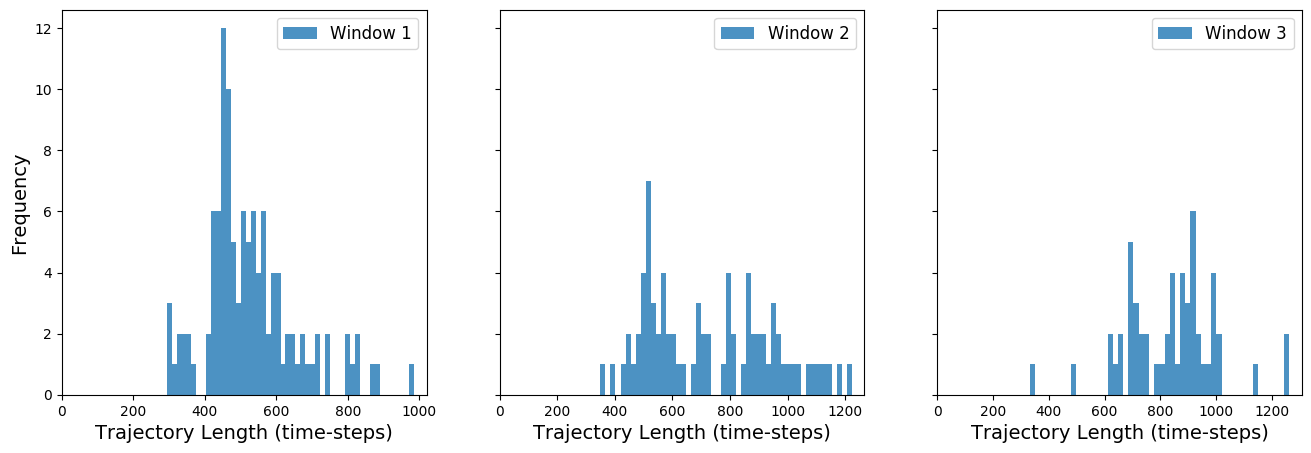

In [10]:
# Trajectory lengths
# This unique below looks at unique value for each groupby
traj_len_one = [frame[0] for frame in df_one_4.groupby('Vehicle_ID')['Total_Frames'].unique().values] 
traj_len_two = [frame[0] for frame in df_two_4.groupby('Vehicle_ID')['Total_Frames'].unique().values] 
traj_len_three = [frame[0] for frame in df_three_4.groupby('Vehicle_ID')['Total_Frames'].unique().values] 

print(f"Trajectory lengths:\n\tFirst window: {len(traj_len_one)}\n\tSecond window: {len(traj_len_two)}\n\tThird window:{len(traj_len_three)}")

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,5), dpi=100, sharey=True)
n_bins = 50

ax1.hist(traj_len_one, bins = n_bins, alpha = 0.8, label = 'Window 1');
ax1.set_xlabel('Trajectory Length (time-steps)', fontsize=14)
ax1.set_ylabel('Frequency', fontsize=14)
ax1.legend(fontsize=12)
ax1.set_xticks(np.arange(0, max(traj_len_one)+100, 200))

ax2.hist(traj_len_two, bins = n_bins, alpha = 0.8, label = 'Window 2');
ax2.set_xlabel('Trajectory Length (time-steps)', fontsize=14)
#ax2.set_ylabel('Frequency', fontsize=14)
ax2.legend(fontsize=12)
ax2.set_xticks(np.arange(0, max(traj_len_two)+100, 200))

ax3.hist(traj_len_three, bins = n_bins, alpha = 0.8, label = 'Window 3');
ax3.set_xlabel('Trajectory Length (time-steps)', fontsize=14)
#ax3.set_ylabel('Frequency', fontsize=14)
ax3.legend(fontsize=12)
ax3.set_xticks(np.arange(0, max(traj_len_three)+100, 200))
plt.show()

### Analysis 2:
- Plot the distribution of average velocities for each vehicle (for the entire trajectory)
- Plot the Histogram of accelerations

Text(0.5, 1.0, 'Window 3')

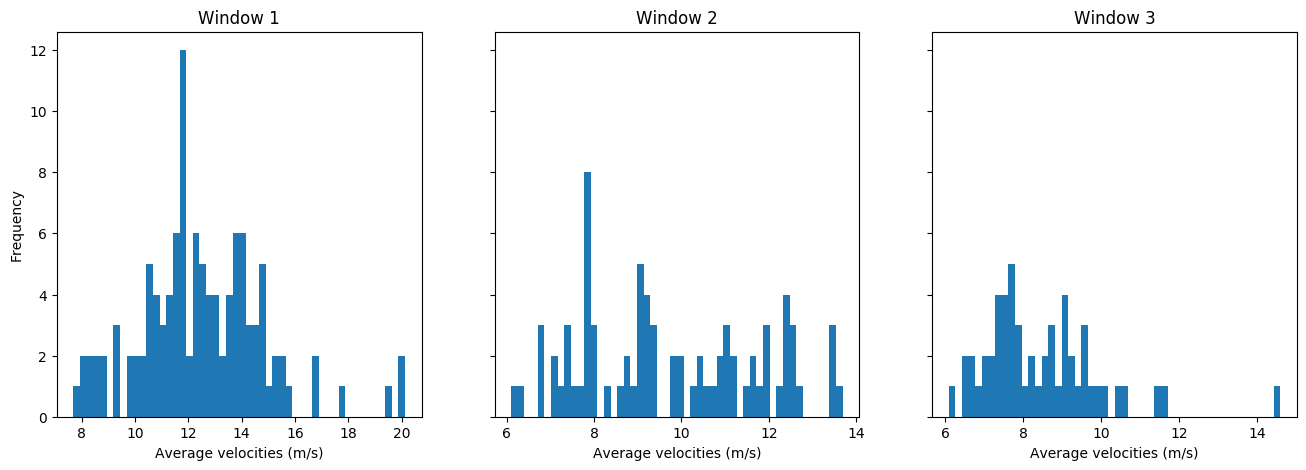

In [11]:
# Plot average velocities for each vehicle
avg_velocities_1 = df_one_4.groupby('Vehicle_ID')['v_Vel'].mean()
avg_velocities_2 = df_two_4.groupby('Vehicle_ID')['v_Vel'].mean()
avg_velocities_3 = df_three_4.groupby('Vehicle_ID')['v_Vel'].mean()

fig, ax = plt.subplots(1,3,figsize=(16,5), dpi=100, sharey=True)
ax[0].hist(avg_velocities_1, bins = n_bins)
ax[1].hist(avg_velocities_2, bins = n_bins)
ax[2].hist(avg_velocities_3, bins = n_bins)

ax[0].set_ylabel("Frequency")
ax[0].set_xlabel("Average velocities (m/s)")
ax[1].set_xlabel("Average velocities (m/s)")
ax[2].set_xlabel("Average velocities (m/s)")

ax[0].set_title("Window 1")
ax[1].set_title("Window 2")
ax[2].set_title("Window 3")

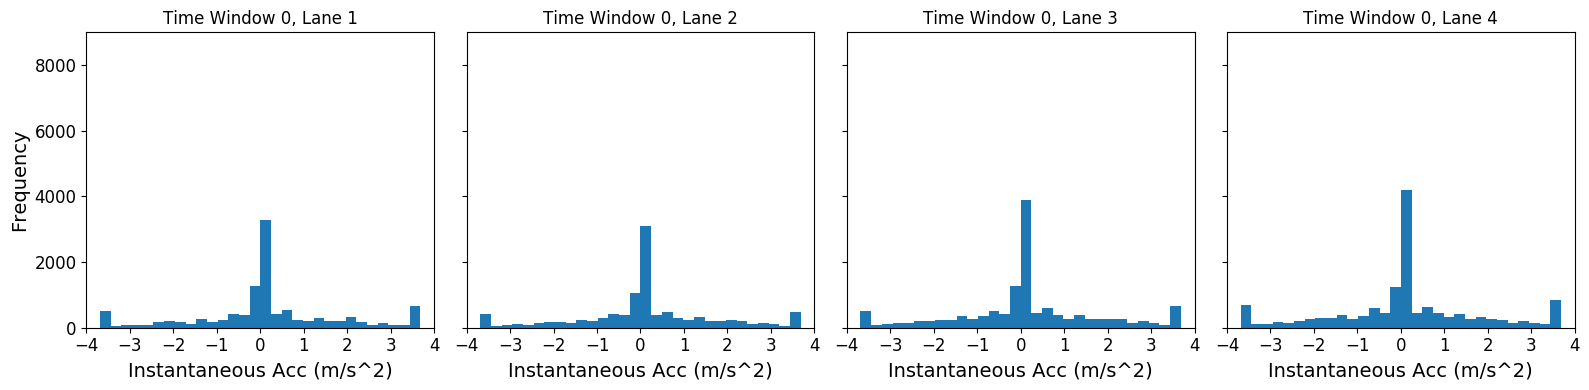

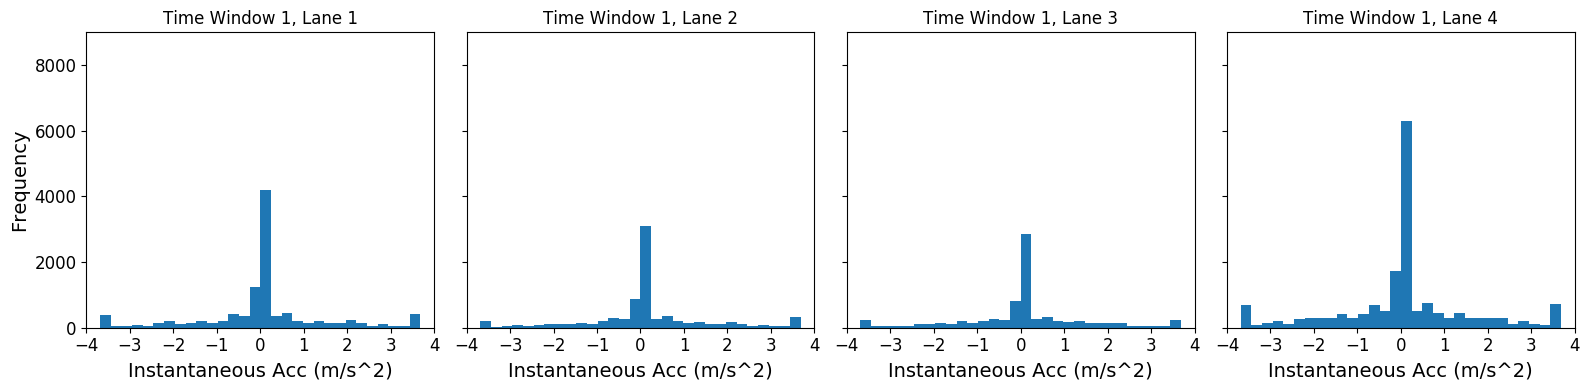

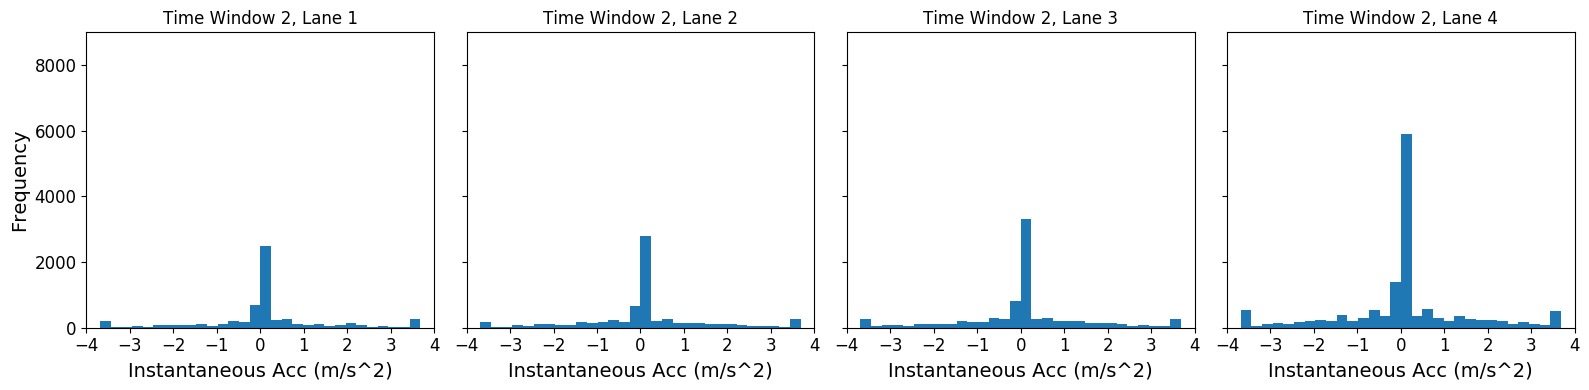

In [12]:
# Histogram of accelerations

grouped_window_one = df_one_4.groupby(['Lane_ID'])
grouped_window_two = df_two_4.groupby(['Lane_ID'])
grouped_window_three = df_three_4.groupby(['Lane_ID'])

grouped_windows = {1: grouped_window_one, 
                   2: grouped_window_two, 
                   3: grouped_window_three}

n_bins = 30

for i in range(3):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4), sharey=True)
    axes[0].set_ylabel('Frequency', fontsize = 14)
    for lane, ax in zip(range(1, 5), axes.flatten()):
        data = grouped_windows.get(i+1).get_group(lane)

        ax.hist(data['v_Acc'], bins=n_bins)
        ax.set_title(f'Time Window {i}, Lane {lane}')
        ax.set_xlabel('Instantaneous Acc (m/s^2)', fontsize = 14)

        ax.tick_params(axis='both', labelsize=12)
        ax.locator_params(axis='x', nbins=10)
        ax.set_xlim([-4,4])
        ax.set_ylim([0,9000])

    fig.tight_layout()
    plt.show()




<Figure size 640x480 with 0 Axes>

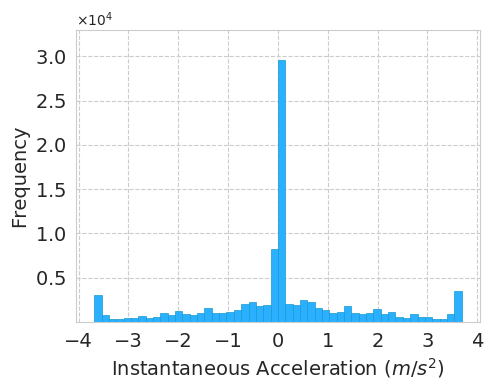

In [13]:
# #histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
# #["#ede15b", "#bdcf32", "#87bc45", "#ea5545", "#ef9b20", "#f46a9b", "#b33dc6", "#27aeef", "#edbf33"]  
# import seaborn as sns
# sns.set_style("whitegrid", {"grid.linestyle": "--"})
# fontsize = 14
# fig, ax = plt.subplots(figsize=(5, 4), dpi=100)
# plt.yticks(fontsize=fontsize)
# plt.xticks(fontsize=fontsize)

# #ax.set_xlim(-1.5e-14,0e-14)
# ax.set_ylim(0, 6.5e3)
# ax.set_yticks(np.linspace(0.0, 6.5e3, 5))

# n_bins = 50
# for i in range(1,3):
#     for j in range(1,5):
#         data = grouped_windows.get(i).get_group(j)['v_Acc']
#         ax.hist(data, bins=n_bins, facecolor = '#2ab0ff', alpha =1.0, edgecolor='#169acf', linewidth=0.5)
        
# # data_window_1_lane_1 = grouped_windows.get(1).get_group(1)['v_Acc']
# # ax.hist(data_window_1_lane_1, bins=n_bins, histtype='barstacked', color='#27aeef')


# #ax.set_title(f'Time Window {i}, Lane {lane}')
# ax.set_xlabel("Instantaneous Acceleration $(m/s^{2})$", fontsize = fontsize)
# ax.set_ylabel("Frequency", fontsize = 14)
  

# fig.tight_layout()
# plt.show()
# plt.savefig('./real_accel.pdf')

import seaborn as sns
import matplotlib.ticker as mticker

sns.set_style("whitegrid", {"grid.linestyle": "--"})
fontsize = 14

plt.subplots_adjust( right=0.5)
fig, ax = plt.subplots(figsize=(5, 4), dpi=100)
fig.subplots_adjust(right=2.85)  # Add padding of 15% of the plot width to the right

plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)

#ax.set_xlim(-1.5e-14,0e-14)
ax.set_ylim(0, 33e3)
ax.set_yticks( [5000, 10000, 15000, 20000, 25000, 30000] )#np.linspace(0.0, 6.5e3, 5))

n_bins = 50
all_data = []
for i in range(1,3):
    for j in range(1,5):
        data = grouped_windows.get(i).get_group(j)['v_Acc'].values
        #print(data.shape)
        all_data.extend(data)
        #print(type(data))

ax.hist(all_data, bins=n_bins, facecolor = '#2ab0ff', alpha =1.0, edgecolor='#169acf', linewidth=0.5)
        
# data_window_1_lane_1 = grouped_windows.get(1).get_group(1)['v_Acc']
# ax.hist(data_window_1_lane_1, bins=n_bins, histtype='barstacked', color='#27aeef')

# Use the ScalarFormatter to format the ytick labels in scientific notation

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
formatter.set_scientific(True)
#formatter.set_precision(1)
ax.yaxis.set_major_formatter(formatter)

#ax.set_title(f'Time Window {i}, Lane {lane}')
ax.set_xlabel("Instantaneous Acceleration $(m/s^{2})$", fontsize = fontsize)
ax.set_ylabel("Frequency", fontsize = 14)

                             
fig.tight_layout()

plt.savefig('./real_accel.pdf', format ='pdf')
plt.show()

In [14]:
all_data = np.asarray(all_data)
total= all_data.shape[0]
total

outside = []
less = all_data[np.where(all_data <-1)]
outside.extend(less)
more = all_data[np.where(all_data >1)]
outside.extend(more)

outside = np.asarray(outside)
print(less.shape, more.shape, outside.shape)

percentage = round(100*(outside.shape[0]/total), 2)
print(percentage)

(16200,) (18630,) (34830,)
37.03


### We can see that:
- Although most instantaneous accelerations line within range [-1,1], there are other peaks as well.
- Discard all instantaneous accelerations in the range [-1,1] and look at others. Where are the peaks?

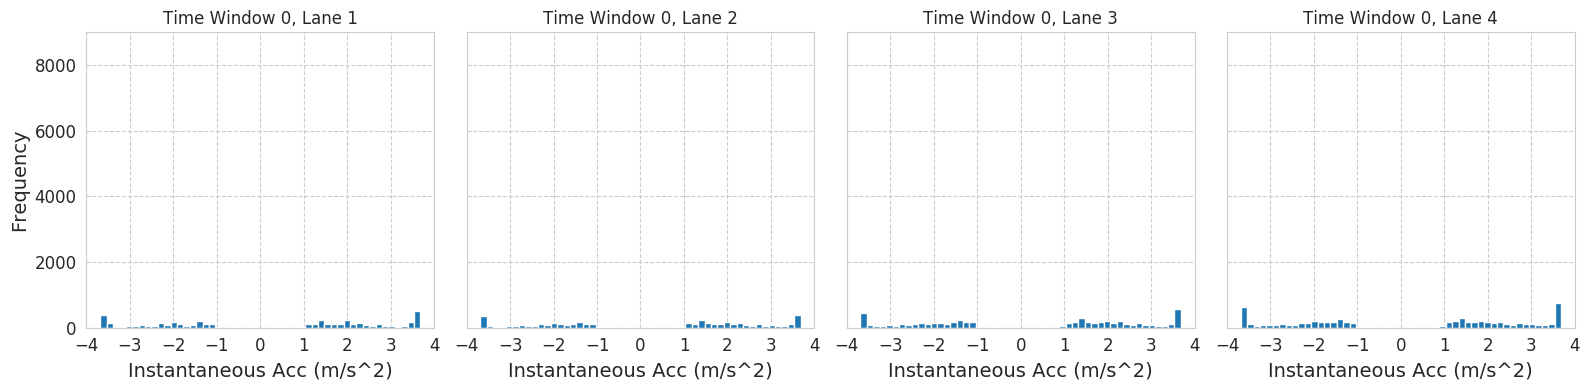

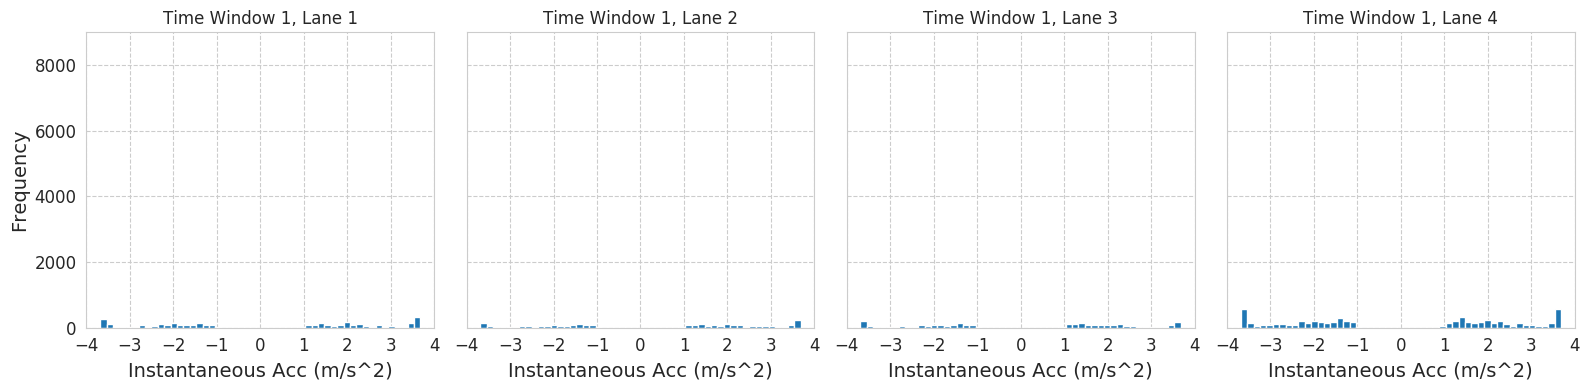

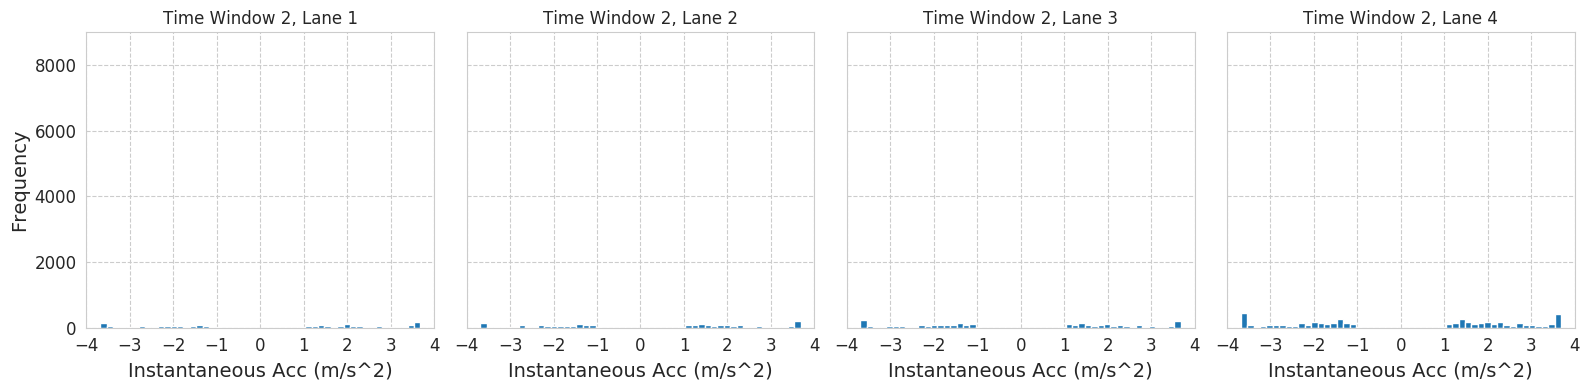

In [15]:
threshold_range = [-1, 1]

for i in range(3):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4), sharey=True)
    axes[0].set_ylabel('Frequency', fontsize = 14)
    for lane, ax in zip(range(1, 5), axes.flatten()):
        data = grouped_windows.get(i+1).get_group(lane)
        outlier_data = data[(data['v_Acc'] < threshold_range[0]) | (data['v_Acc'] > threshold_range[1])]

        ax.hist(outlier_data['v_Acc'], bins=n_bins)
        ax.set_title(f'Time Window {i}, Lane {lane}')
        ax.set_xlabel('Instantaneous Acc (m/s^2)', fontsize = 14)

        ax.tick_params(axis='both', labelsize=12)
        ax.locator_params(axis='x', nbins=10)
        ax.set_xlim([-4,4])
        ax.set_ylim([0,9000])

    fig.tight_layout()
    plt.show()

- There lie a large number of data points outside of the [-1, 1] range
- There are clearly visible peaks between 3 and 4 (average 3.5) and -3 and -4 (average -3.5)

-----------------------

### Analysis 3:
- What is the duration of such peaks?
- What is the frequency (How many times do such peaks occur for every 100 seconds of driving)

In [16]:
dataframes = {1: df_one_4, 2: df_two_4, 3: df_three_4}

# Define the range of v_Acc values to search for
v_Acc_range_1 = [1, 4]
v_Acc_range_2 = [-1, -4]

In [17]:
# For range 1
counts_collector_mother_1 = []
for i in range(3):
    df = dataframes.get(i+1)
    df['in_range'] = (df['v_Acc'] >= v_Acc_range_1[0]) & (df['v_Acc'] <= v_Acc_range_1[1]).astype(int)

    current_count = 0 
    counts_collector = []

    for i, r in df.iterrows():
        current = int(r['in_range'])

        if current==1: 
            current_count+=1

        if current ==0:
            # only append if current_count is > 1
            if current_count>1:
                counts_collector.append(current_count)
            current_count = 0

        #print(f" row: {i}, current count: {current_count}")

    counts_collector = np.asarray(counts_collector)
    print(f"Unique count values (number of timesteps): {np.unique(counts_collector)}")
    counts_collector_mother_1.append(counts_collector)

flattened_mother_1 = []
for j in counts_collector_mother_1:
    for k in j:
        flattened_mother_1.append(k)
        
flattened_mother_1 = np.asarray(flattened_mother_1)
print(f"\nMedian duration of peak for the first range: {np.median(flattened_mother_1)} timesteps")

Unique count values (number of timesteps): [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 17]
Unique count values (number of timesteps): [ 2  3  4  5  6  7  8  9 10 11 12 14 18]
Unique count values (number of timesteps): [ 2  3  4  5  6  7  8  9 10 11 13]

Median duration of peak for the first range: 4.0 timesteps


In [18]:
# For range 2
counts_collector_mother_2 = []
for i in range(3):
    df = dataframes.get(i+1)
    df['in_range'] = (df['v_Acc'] >= v_Acc_range_2[1]) & (df['v_Acc'] <= v_Acc_range_2[0]).astype(int)

    current_count = 0 
    counts_collector = []

    for i, r in df.iterrows():
        current = int(r['in_range'])

        if current==1: 
            current_count+=1

        if current ==0:
            # only append if current_count is > 1
            if current_count>1:
                counts_collector.append(current_count)
            current_count = 0

        #print(f" row: {i}, current count: {current_count}")

    counts_collector = np.asarray(counts_collector)
    print(f"Unique count values (number of timesteps): {np.unique(counts_collector)}")
    counts_collector_mother_2.append(counts_collector)

flattened_mother_2 = []
for j in counts_collector_mother_2:
    for k in j:
        flattened_mother_2.append(k)
        
flattened_mother_2 = np.asarray(flattened_mother_2)
print(f"\nMedian duration of peak for the second range: {np.median(flattened_mother_2)} timesteps")

Unique count values (number of timesteps): [ 2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 19 25]
Unique count values (number of timesteps): [ 2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 22]
Unique count values (number of timesteps): [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 19]

Median duration of peak for the second range: 3.0 timesteps


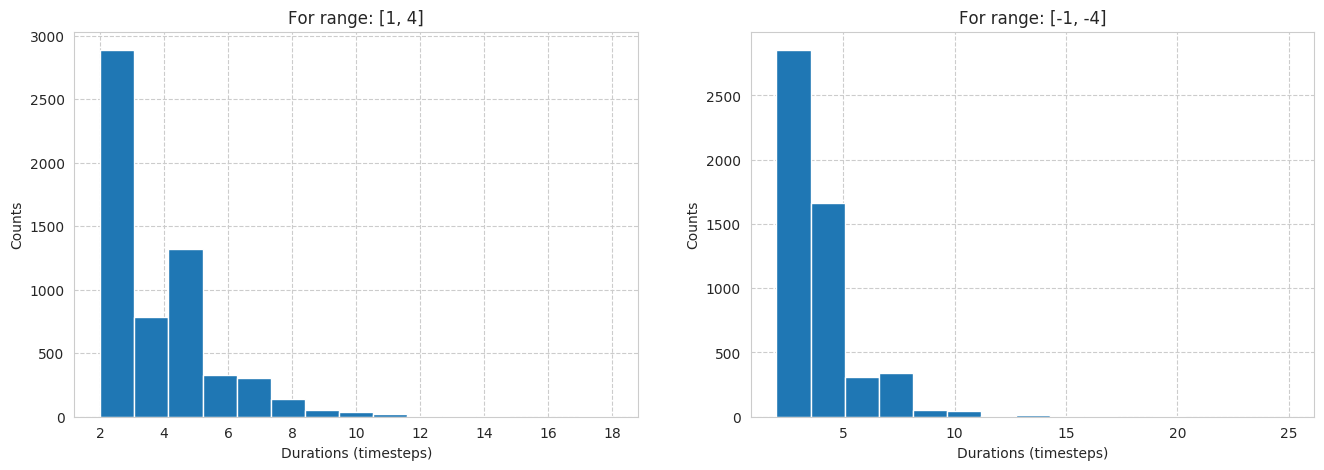

In [19]:
fig, ax = plt.subplots(1,2, figsize = (16,5), dpi = 100)
n_bins = 15

ax[0].hist(flattened_mother_1, bins=n_bins);
ax[1].hist(flattened_mother_2, bins=n_bins);
ax[0].set_xlabel("Durations (timesteps)")
ax[0].set_ylabel("Counts")
ax[1].set_xlabel("Durations (timesteps)")
ax[1].set_ylabel("Counts")
ax[0].set_title(f"For range: {v_Acc_range_1}");
ax[1].set_title(f"For range: {v_Acc_range_2}");

Frequency: 
- If such an event were to occur for a vehicle, one event of driving at such peaks occurs for every 30 seconds of driving.
- Or 3.3 such events occur for 100 seconds of driving/
- Or 10 such events occur for 300 seconds (3000 timesteps) of driving.

-----------------------

### Analysis 4:

Since our analysis is at 22mph linearly scale the obtained acceleration (divide by 55/22 = 2.5) values to finally obtain:

__Shock Model 1:__

    Acceleration: (3.5/2.5) = 1.4 m/s2
    Duration: 20 timesteps (at worst)
    Frequency: Once for every 30 seconds of driving

__Shock Model 2:__

    Acceleration: (-3.5/2.5) = -1.4 m/s^3
    Duration: 20 timesteps (at worst)
    Frequency: Once for every 30 seconds of driving

In [20]:
#-4/2.5 = -1.6

### Final Figure
- To the figure above, add a typical IDM accelerations
- When all vehicles are IDM, in various densities in the ring from 70 to 120 veh/km 
- We have an option to look at realized or target accelerations. Realized accelerations are limited because SUMO safety comes into effect, however, target acclerations (target_accel_with_noise_no_failsafe) is what is generated by IDM

In [21]:
import os 
import random

directory = './Typical_IDM_data/'
files = os.listdir(directory)
file_directories = [] 
for i in files:
    file_directories.append(directory + i)
file_directories

['./Typical_IDM_data/idm_20230814-0934541692020094.644299-0_emission.csv',
 './Typical_IDM_data/idm_20230814-0935251692020125.6047704-0_emission.csv',
 './Typical_IDM_data/idm_20230814-0935541692020154.0609777-0_emission.csv',
 './Typical_IDM_data/idm_20230814-0936211692020181.9302511-0_emission.csv']

In [22]:
# Accelerations should not be in free flow, neither should they be in SGT
# get all idm vehicles acceleration data before shock time
def get_realized_accel(data, start_time, end_time):
    # get all unique vehicle ids
    vehicle_ids = data['id'].unique()

    # get all idm vehicles, if the id has human 
    idm_vehicles = [id for id in vehicle_ids if 'idm' in id]

    all_vehicle_data = []
    # get all idm vehicles acceleration data before shock time
    for veh in idm_vehicles:
        veh_data = data[data['id'] == veh]
        # Include both start and end time
        veh_data = veh_data[(veh_data['time'] >= start_time) & (veh_data['time'] <= end_time)]
        #veh_data = veh_data[veh_data['time'] > start_time]
        # just get realized_accel 
        veh_data = veh_data['target_accel_with_noise_no_failsafe']
        all_vehicle_data.append(veh_data)
    return all_vehicle_data

In [23]:
# For a certain initial period the system is mostly stable and near zero accelerations are present
start_time = 100
end_time = 220 

all_data_idm = []
for j in file_directories:
    data = get_realized_accel(pd.read_csv(j), start_time, end_time)
    for k in data:
        all_data_idm.extend(k)
print(len(all_data_idm)) # The total volume of data has to be the same (to just look at thier distributions)\

# randomly sample (with equal probability) the same volume 
all_data_idm_sampled = all_data_idm#random.sample(all_data_idm, len(all_data))
print(len(all_data))
print(len(all_data_idm_sampled))

105688
94053
105688


/home/kurukshetra/anaconda3/envs/flow/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/kurukshetra/anaconda3/envs/flow/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([2.0000e+00, 3.3000e+01, 4.0400e+02, 3.4150e+03, 4.9530e+03,
        8.4190e+03, 3.5257e+04, 3.3726e+04, 1.4941e+04, 4.3150e+03]),
 array([-2.1771547 , -1.86656326, -1.55597183, -1.24538039, -0.93478896,
        -0.62419752, -0.31360609, -0.00301465,  0.30757678,  0.61816821,
         0.92875965]),
 <a list of 10 Patch objects>)

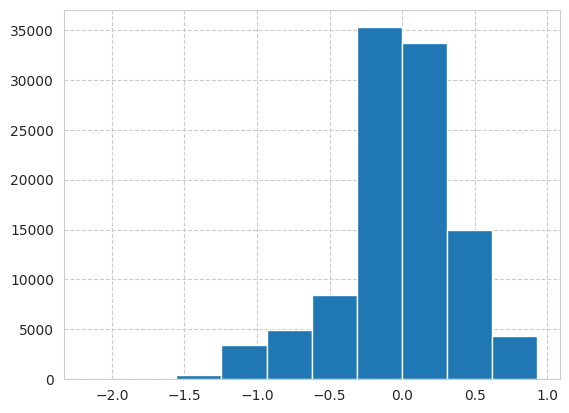

In [24]:
plt.hist(all_data_idm_sampled)

<Figure size 640x480 with 0 Axes>

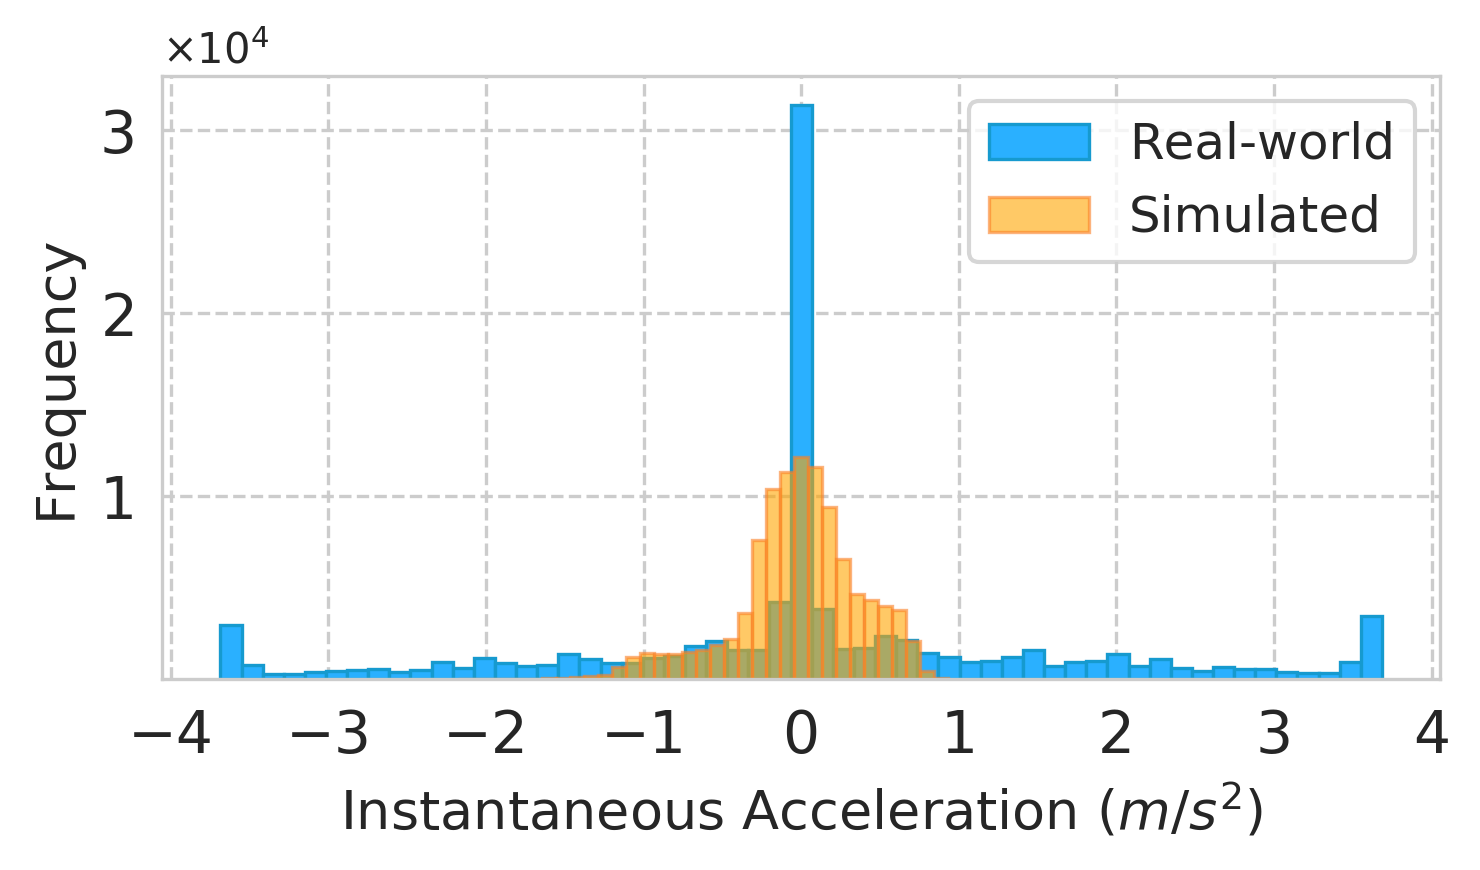

In [25]:
import seaborn as sns
import matplotlib.ticker as mticker
plt.rcParams["text.color"] = 'black'

sns.set_style("whitegrid", {"grid.linestyle": "--"})

plt.subplots_adjust( right=0.5)
fig, ax = plt.subplots(figsize=(5, 3), dpi=300)
fig.subplots_adjust(right=2.85)  # Add padding of 15% of the plot width to the right

plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)

#ax.set_xlim(-1.5e-14,0e-14)
ax.set_ylim(0, 33e3)
ax.set_yticks( [10000, 20000, 30000] )#np.linspace(0.0, 6.5e3, 5))

n_bins = 55
all_data = []
for i in range(1,3):
    for j in range(1,5):
        data = grouped_windows.get(i).get_group(j)['v_Acc'].values
        #print(data.shape)
        all_data.extend(data)
        #print(type(data))

ax.hist(all_data, bins=n_bins, facecolor = '#2ab0ff', alpha =1.0, edgecolor='#169acf', linewidth=0.8, label = "Real-world")# ,histtype="stepfilled", zorder=1)
ax.hist(all_data_idm_sampled, bins=n_bins-20, facecolor = '#FFA500', alpha =0.6, edgecolor='#FA8128', linewidth=0.8, label = "Simulated") #, histtype="stepfilled", zorder=2)
 
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
formatter.set_scientific(True)
#formatter.set_precision(1)
ax.yaxis.set_major_formatter(formatter)

fs = 13

#ax.set_title(f'Time Window {i}, Lane {lane}')
ax.set_xlabel("Instantaneous Acceleration $(m/s^{2})$", fontsize = fs)
ax.set_ylabel("Frequency", fontsize = fs)


ax.legend(fontsize = fs-1)                             
fig.tight_layout()
plt.savefig('./real_accel.pdf', format ='pdf')
plt.savefig('./real_accel_png.png')
plt.show()

In [26]:
# What % of the IDM data is contained within [-1,1] range?
a = np.array(all_data_idm_sampled)

percentage_within_range = np.mean((a >= -1) & (a <= 1)) * 100
percentage_within_range

/home/kurukshetra/anaconda3/envs/flow/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater_equal
  after removing the cwd from sys.path.
/home/kurukshetra/anaconda3/envs/flow/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less_equal
  after removing the cwd from sys.path.


97.13023238210582